1KG
==
Run on $k$-SFS computed from 1000 Genome Project data

In [1]:
%matplotlib inline 
#%matplotlib notebook
import ancestor
import mushi
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import expit
import time
import msprime
%cd stdpopsim
from stdpopsim import homo_sapiens
%cd ../

/Users/williamdewitt/Desktop/repos/dement/stdpopsim
/Users/williamdewitt/Desktop/repos/dement


In [104]:
for chro in (22,): #range(1, 23):
    snps = pd.read_csv(f'scons_output/snps.3mer.{chro}.tsv', sep='\t', index_col=0)
    n = snps.n.iloc[0]
    assert all(snps.n == n)    
    this_ksfs = snps.groupby(['sample frequency',
                              'mutation type']).size().unstack('mutation type',
                                                               fill_value=0)
    if chro == 1:
        ksfs_CEU = this_ksfs
    else:
        ksfs_CEU += this_ksfs
    assert this_ksfs.shape[0] == n - 1

mutation_types = ksfs_CEU.columns
ksfs_CEU

mutation type,AAA>ACA,AAA>AGA,AAA>ATA,AAC>ACC,AAC>AGC,AAC>ATC,AAG>ACG,AAG>AGG,AAG>ATG,AAT>ACT,...,TCA>TTA,TCC>TAC,TCC>TGC,TCC>TTC,TCG>TAG,TCG>TGG,TCG>TTG,TCT>TAT,TCT>TGT,TCT>TTT
b,,,,,,,,,,,,,,,,,,,,,
1,1705,2912,1000,763,2115,524,896,2304,498,860,...,3380,1137,1111,4355,251,261,4971,1537,2020,4002
2,477,823,250,249,561,140,211,600,117,208,...,894,297,325,1345,72,86,1318,372,507,1206
3,288,520,154,167,345,83,121,391,66,133,...,580,177,178,837,37,45,779,228,318,699
4,181,367,126,84,215,62,85,276,47,94,...,373,140,122,593,24,37,547,149,232,476
5,153,268,92,80,178,48,82,206,38,85,...,316,101,100,414,27,34,415,129,166,355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,9,8,7,3,10,5,2,7,1,0,...,13,4,3,15,1,1,12,9,10,15
194,6,10,4,2,8,3,4,9,3,3,...,14,2,4,14,1,2,7,2,6,13
195,12,13,5,0,17,3,4,15,3,5,...,12,7,3,14,5,1,10,5,7,11


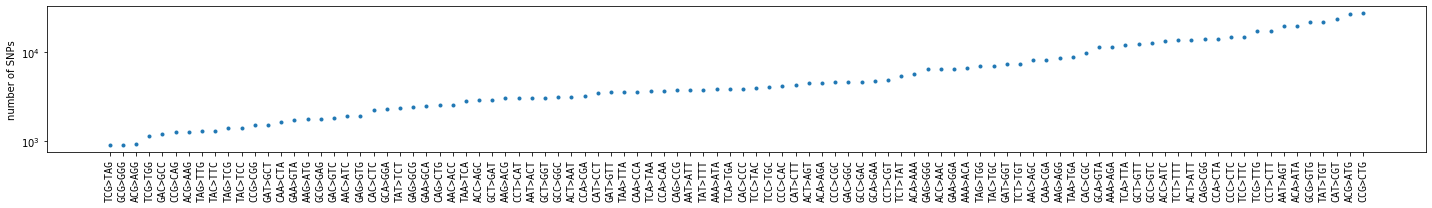

In [105]:
df = ksfs_CEU.sum().sort_values().to_frame()
plt.figure(figsize=(20, 3))
plt.plot(df, '.')
plt.xticks(rotation='vertical', family='monospace')
plt.ylabel('number of SNPs')
plt.yscale('symlog')
plt.tight_layout()
plt.savefig('/Users/williamdewitt/Downloads/foo.png')
plt.show()

In [101]:
df.max() / df.min()

0    32.194219
dtype: float64

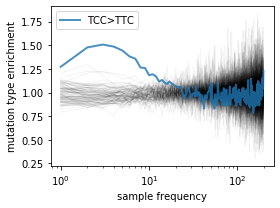

In [4]:
plt.figure(figsize=(4, 3))
foo = ksfs_CEU
foo = foo / foo.values.sum(1, keepdims=True)
foo = foo / foo.mean(0)
plt.plot(foo, c='k', lw=1, alpha=0.05)
plt.plot(foo['TCC>TTC'], label='TCC>TTC', c='C0', lw=2, alpha=0.8)
plt.xlabel('sample frequency')
plt.ylabel('mutation type enrichment')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# plt.style.use('dark_background')

### Time grid

In [6]:
t = np.logspace(0, np.log10(3e4), 300)

### Demographic history $\eta(t)$ from the European population in Tennessen et al.

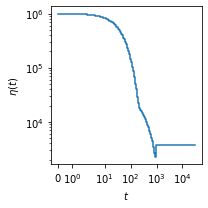

In [7]:
model = homo_sapiens.TennessenTwoPopOutOfAfrica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η = mushi.η(t, y)

plt.figure(figsize=(3, 3))
η.plot()
plt.show()

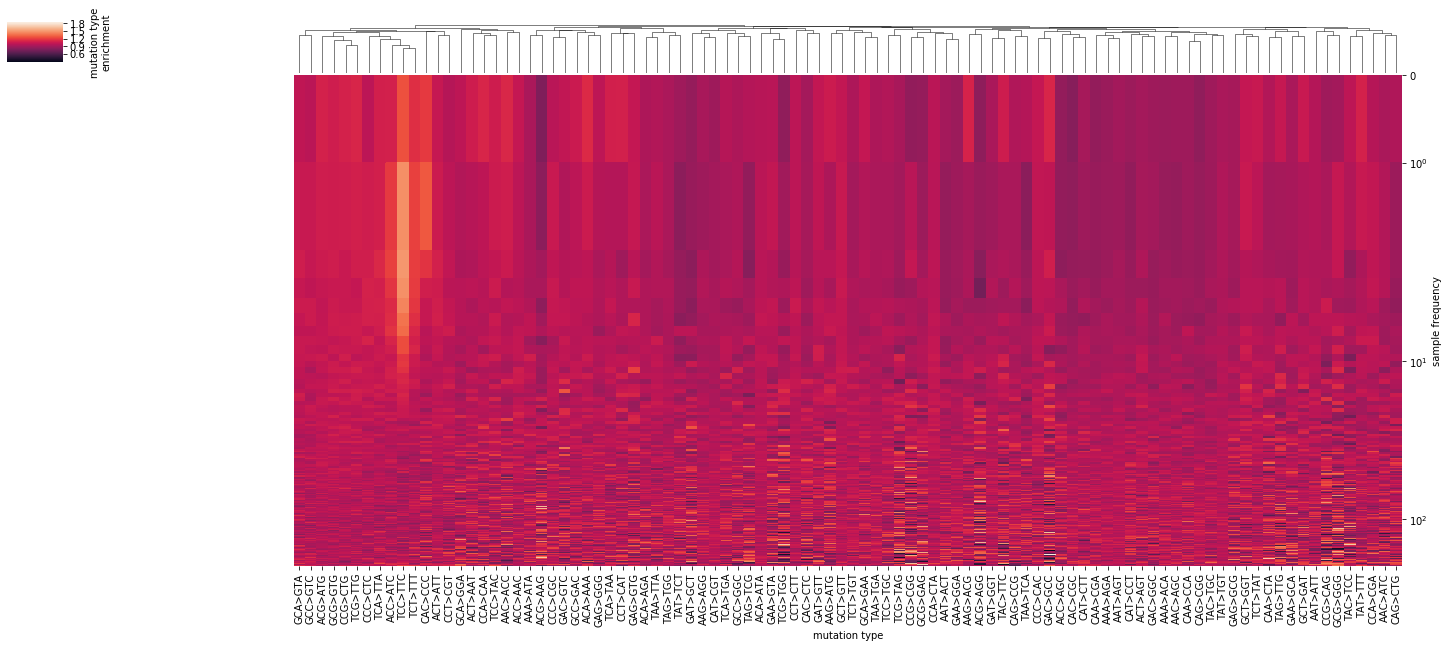

In [8]:
ksfs = mushi.kSFS(η, X=ksfs_CEU.values, mutation_types=mutation_types)

ksfs.clustermap(figsize=(25, 10))
plt.show()
# plt.savefig('/Users/williamdewitt/Downloads/sfs.pdf', transparent=True)

### TMRCA CDF

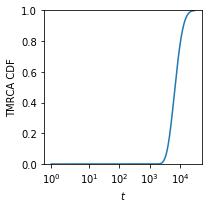

In [9]:
plt.figure(figsize=(3, 3))
plt.plot(η.change_points, ksfs.tmrca_cdf())
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Invert the $k$-SFS conditioned on $\eta(t)$ to get $\boldsymbol\mu(t)$
Accelerated proximal gradient descent

In [35]:
μ_inferred, f_trajectory = ksfs.infer_μ(# loss function parameters
                                        fit='prf',
                                        exclude_singletons=False,
                                        bins=None,
                                        # time derivative regularization parameters
                                        λ_tv=1e1,
                                        α_tv=0,#0.999,
                                        # spectral regularization parameters
                                        λ_r=0,#1e2,
                                        α_r=1,#.999999,
                                        hard=True,                                        
                                        # convergence parameters
                                        max_iter=10000,
                                        tol=1e-10,
                                        γ=0.8)

maximum iteration 10000 reached with relative change in loss function 5.6e-10


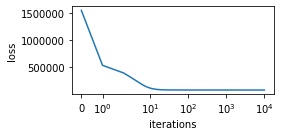

In [36]:
plt.figure(figsize=(4, 2))
plt.plot(f_trajectory)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.xscale('symlog')
plt.tight_layout()
plt.show()

The inferred histories for each mutation type

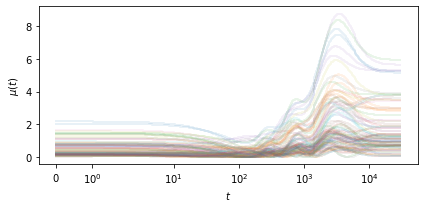

In [37]:
plt.figure(figsize=(6, 3))
μ_inferred.plot(alpha=0.1, lw=2)
plt.show()
# plt.savefig('/Users/williamdewitt/Downloads/mu.pdf', transparent=True)

Heatmap of the inferred mutation spectrum history

In [ ]:
μ_inferred.clustermap(figsize=(25, 10))
plt.show()

plot $\chi^2$ goodness of fit for each $k$-SFS matrix element, and compute $\chi^2$ goodness of fit test for the $k$-SFS matrix as a whole

In [ ]:
ksfs.clustermap(μ_inferred, figsize=(25, 10), cmap='Reds')
plt.show()

In [ ]:
f, axes = plt.subplots(96, 1, sharex=True, figsize=(3, 96))
for ct, i in enumerate(range(96)):
    plt.sca(axes[ct])
    ksfs.plot(i, μ=μ_inferred, prf_quantiles=True)
    plt.ylabel(μ_inferred.mutation_types[ct])
    if ct < 95:
        plt.xlabel(None)
plt.tight_layout()
plt.show()

### Singular value spectrum of $Z$

In [ ]:
plt.figure(figsize=(3, 3))
plt.bar(range(μ_inferred.Z.shape[1]), np.linalg.svd(μ_inferred.Z, compute_uv=False))
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ksfs_1)

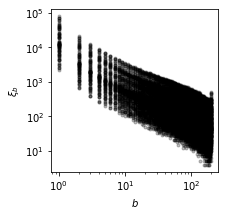

In [40]:
plt.figure(figsize=(3, 3))
for i in range(ksfs.X.shape[1]):
    ksfs.plot(i)
plt.show()